In [ ]:
# Mounting to Google Drive:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


***Data Pre-processing***

Data pre-processing / feature engineering is arguably the most important step in creating a reliable and well performing CNN model. Modern deep learning already automates much of feature extraction, but the effects of good feature engineering can still significantly enhance model performace, this is especially the case when dealing with limited data. The dataset that has been provided consists of thousands of photographs of waste that are labelled into 9 different types of classes, ranging from metal, cardboard, vegetation, etc. This means that we are dealing with a multiclass classfication problem with images (Rank 4 tensors). The most effective way to pre-process data in the form of images include rescaling, ensuring that the images fit the dimensional requirements of the model. In the case of my model, the images were rescaled to 256x256 pixels, this amount of pixels seemed to provide a good balance for computational efficiency and allows the model to gather detailed feature extraction. Data augmentation was another key step in pre-processing realwaste data. The original study conducted by single et al. included multiple types of data augmentation, ranging from random flipping, rotation, translation, etc. Seeing how effective data augmentation can be for model performance, both theoretically and practically, I also included this in my model in hopes of reducing the probability of my model having poor generalization of new unseen data. The batch size selected in the pre-processing step of the model was 32, multiple batch sizes were tested such as 64, and 128, but it seemed that the trade off for model efficiency and the quality of the gradient estimation showed greatest promise when the batch size was set to 32. Other methods used to pre-process the data were normalization, where the pixel values are divided by 255 in order to standardize input data (between 0 and 1), this should help the model converge faster while training. Finally, the data is split into training and validation to ensure that the model generalizes well with new data. Some potential issues that could limit the effectiveness of data pre-processing can be seen in the pictures above. The first image with the labels "original" and "augmented" show what happens to the images when the different data augmentation techniques are used. However, in the second image, it seems that the raw data includes multiple pictures of the same object that are placed in different orientations. This raises multiple concerns since the data is randomly split, and it is possible that images of the same object have leaked into the validation set, which could mean that the model is memorizing the object in question, leading to a potential decrease in model generalization capability. Solutions that I can think of to avoid data leakage are to use either a stratified splitting technique, or another way would be to manually ensure images of the same object do not show up in both training and validation datasets, but this would be extremely time consumming.

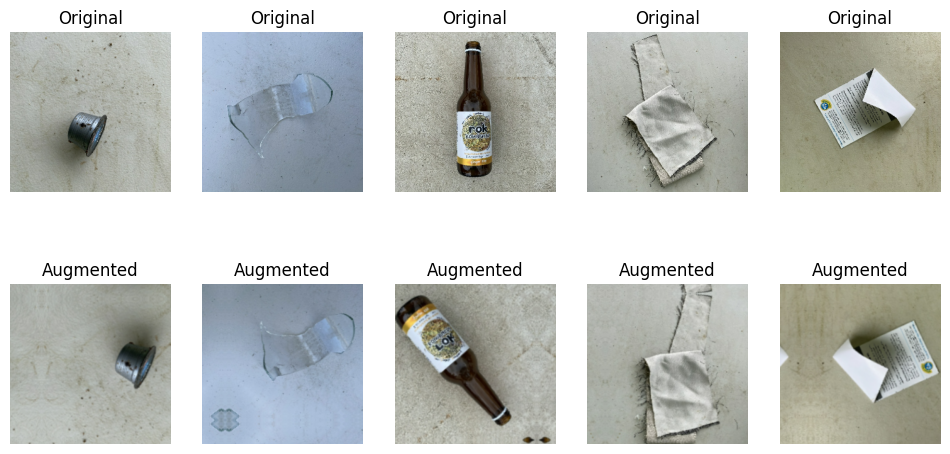

***Preliminary Setup and running my Pre-Trained Model***

In [ ]:
# Set up paths and dataset:
dataset_path = '/content/gdrive/My Drive/ML2/realwaste-main/RealWaste'

# Loading in the necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

# Load and create training and validation data sets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

def create_mobilenetv2_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers of the base model
    base_model.trainable = False

    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Data augmentation
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(0.2, 0.2),

        # Data normalization
        layers.Rescaling(1./255),

        # MobileNetV2 base model
        base_model,

        # Global Average Pooling layer
        layers.GlobalAveragePooling2D(),

        # Dropout and Dense layers
        layers.Dropout(0.5),
        layers.Dense(1280, activation='relu'),  # Dense layer with 1280 units
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

input_shape = (256, 256, 3)  # Height, width, and RGB
num_classes = 9  # Number of classes in the dataset

model = create_mobilenetv2_model(input_shape, num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

checkpoint_path = '/content/gdrive/My Drive/ML2/MobileNetV2.keras'
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_loss'
)

early_stopping_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Train the model
epochs = 120
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[checkpoint_callback, early_stopping_callback]  # Pass callbacks to training
)

Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.


<ipython-input-2-38e636f7c3fd>:32: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 256, 256, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1280)                │       1,639,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │          11,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,909,193 (14.91 MB)

 Trainable params: 1,651,209 (6.30 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.3800 - loss: 1.8012 - val_accuracy: 0.6863 - val_loss: 0.9635
Epoch 2/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.6003 - loss: 1.0917 - val_accuracy: 0.7168 - val_loss: 0.8103
Epoch 3/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.6424 - loss: 0.9851 - val_accuracy: 0.7337 - val_loss: 0.7454
Epoch 4/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.6840 - loss: 0.8817 - val_accuracy: 0.7421 - val_loss: 0.7358
Epoch 5/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.7032 - loss: 0.8586 - val_accuracy: 0.7547 - val_loss: 0.6844
Epoch 6/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.7145 - loss: 0.8089 - val_accuracy: 0.7632 - val_loss: 0.6646
Epoch 7/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.7091 - loss: 0.8053 - val_accuracy: 0.7684 - val_loss: 0.6533
Epoch 8/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.7296 - loss: 0.7484 - 

***Discussing chosen model architecture***

The goal of this model is to perform a multiclass classification on the RealWaste dataset. My best performing Pre-trained model uses a sequential model that also incorporates the MobileNetV2 architecture as the base model. The reason I chose to use the MobileNetV2 pre-trained model because it was used in the study conducted by Single et al., and because the model is known for efficiency, providing a good balance between computational cost and accuracy. The data augmentation layer and the rescaling layer have already been touched upon in the previous question, therefore this will be skipped. The MobileNetV2 base model has already been pre-trained on the "ImageNet" dataset, which allows the model to leverage transfer learning, this is done by utilizing the features that have already been learnt from the large "ImageNet" database. In theory this should be extremely beneficial when running the model on the RealWaste dataset, which is relatively small compared to the ImageNet dataset. Lastly, I made the decision to freeze all of the layers in the base mode. This was done partly because I wanted to retain the learned features while focusing on the new classification, and also because unfreezing the layers one at a time did not improve accuracy or decrease loss. There could be multiple reasons for this, insufficient data is one of them, since the ImageNet dataset was much bigger. Other reasons could include the base model 'forgetting' some of the important features that allowed it to perform well when frozen. This could also be an issue regarding the learning rate being suboptimal, meaning that the unfrozen layers are not capturing all of the necessary features. Global average pooling is used to change the compress the image (Rank 4 tensor) into a vector (Rank 2 tensor). I found that including global average pooling reduces the risk of the model overfitting, and also reduces the computational demand required to run the model. The dense layers that follow have 1280 units, this is to ensure that there is no information bottleneck between the base model and the fully connected layer, since the base MobileNetV2 model uses 1280 units. The dropout layer is there to set a fraction of the inputs to zero during training, this ensures that the model is not memorizing images while training. It is set to 0.5 since this is the standard, which seemed to be quite effective in balancing model capacity and model generalization. The final dense layer has 9 units, this is done to match the 9 possible classes the images could be potentially classified. The softmax function necessary since this is a multiclass problem, and allows for the weights of 9 classes combined to be equal to 1. Other model architectures such as ResNet50 and InceptionV3 were considered and tested. However, MobileNetV2 was preferred due to its lower computational cost and the sufficient accuracy it provides for the classifying images of waste. Other techniques to improve model performace have been tested with this model, such as L2 Regulization, residual connections, and normalization. But this is seemed to not provide a significant improvement to the already existing model, which could be due to high complexity when compared to the amount of images, or it could also be pretrained layers are already sufficiently good.


***Plotting the accuracy and loss for training and validation***

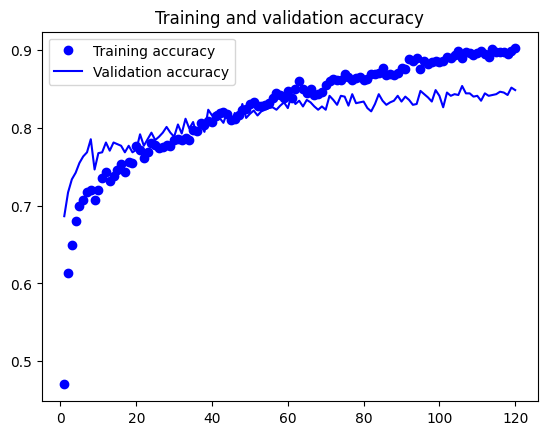

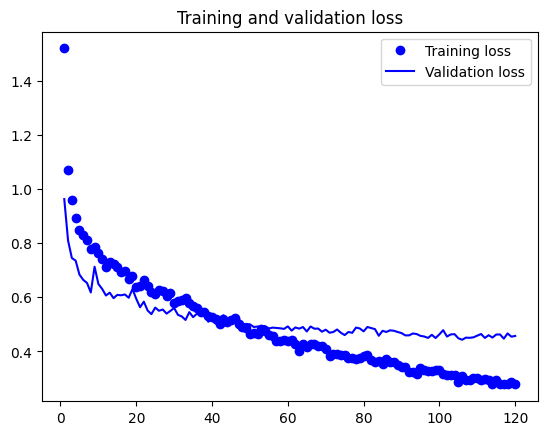

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8264 - loss: 0.5116
Validation Loss: 0.44293078780174255
Validation Accuracy: 0.8536841869354248


In [ ]:
# Plotting the training and validation accuracy and loss values
def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

plot_history(history)

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

***Discussing the results based on accuracy and loss plot***

The optimizer that was used for the model was Adam, with the learning_rate set to 0.0001. The Adam optimizer was used for the model because it uses momentum to smooth out fluctuations in the optimization process, which can help the optimizer avoid local minima and saddle points. Combined with a learning rate of 0.0001, the model seemed to be able to learn and generalize the data quite well as can be seen with by the minimal fluctuations in the plots above. The callbacks for the best pre-trained model were used in order to save only the best validation loss, which in the case of this model was 0.44. Furthermore, in order for the model to not run for extremely long, an early stopper was implemented with patience of 15, which means that the model will no longer keep running if the validation loss does not decrease in 15 consecutive epochs. The training accuracy curve shows a consistent upward trend starting from around 50% and ending at 90% at around 120 epochs. This means that the model is effectively learning the patterns from the training data.The validation accuracy begins at quite high at approximately 68%, which is higher than the training accuracy at that epoch, this is likely due to using a pretrained model instead of starting from scratch. However, it seems that the validation accuracy seems to show only minor increase with fluctuation from approximately 40 epoch to 120 epoch. The change from a smooth increase to a less predictable fluctuation shows that model seems to be able to overfit. The training loss shows consistent decrease starting from 1.4 and ending below 0.4. This is expected and corresponds with the increase in training accuracy. The validation loss decreases initially, mirroring the trend seen in the validation accuracy. However, the loss begins to plateau and then slightly increase after approximately 40 epoch, which indicates that the model is strating to memorize the training data and is starting to overfit. This also aligns with what is seen in the validation accuracy. The best validation accuracy and loss (0.44 and 0.85) is at approximately 100 to 110 epochs, which indicates that this is the local minimum based on the idea of stochastic gradient decent. Methods that could be used to increase the effectiveness of the models include adjusting the learning rate, or including other regulaization techniques which were mentioned in the previous question.

***Defining a function in order to pre-process the test image***

In [ ]:
def preprocess_image(image_url, image_id):
  # Download the image
  image_path = tf.keras.utils.get_file(image_id, origin=image_url)

  # Load the image
  img = tf.keras.utils.load_img(image_path, target_size=(256, 256))

  # Convert the image to an array
  img_array = tf.keras.utils.img_to_array(img)

  # Expand dimensions to match the expected input format
  img_array = tf.expand_dims(img_array, 0)

  # Rescale the pixel values to the range [0, 1]
  img_array = img_array / 255.0

  return img_array

***Letting the model predict an image***

In [ ]:
# Predicting the most likely class for the image

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Class name based on the naming from the original files
class_name = [
    'Cardboard',
    'Food Organics',
    'Glass',
    'Metal',
    'Miscellaneous Trash',
    'Paper',
    'Plastic',
    'Textile Trash',
    'Vegetation'
]

# Preprocess the image
processed_image = preprocess_image('https://upload.wikimedia.org/wikipedia/commons/e/eb/Box.agr.jpg', 'Box.agr')

# Make a prediction using the trained model
predictions = model.predict(processed_image)

# Decode the prediction
predicted_class = class_name[np.argmax(predictions)]

print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Class: Miscellaneous Trash


***Discussion of the Predicted Class***

My best pre-trained model predicted the image of the box as miscellanous trash, there are multiple reasons that can be attributed to why the model was unable to correctly predict the class of the image. Firstly is the issue that revolves around optimization and generalization. It is possible that my model has optimized (perform better on the training set) that it has for generalizing data in the validation set. This can lead to the model memorizing which leads to worse performance of the test image. Another reason for the model falsely predicting the image could be because certain features have higher weights put on to it, leading to less accurate predictions. One way I could have potentially avoided this was to make the model deeper by including more layers, this may have allowed to model to capture the more important features it needs to perform good classification. Finally, since the pre-trained model was trained on the "ImageNet" dataset, it is possible that the features that were extracted from that dataset would make it classify this image as miscellaneous instead of cardboard. The general idea is between model optimization and model generalization, and one of the key challenges that alot of people face today is to build a model that can geenralize well on multiple tensors that may have different context. But what can be seen in the results from my model show that getting a model to generalize well is not as easy as it may seem.
